In [2]:
import numpy as np
import scipy
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math

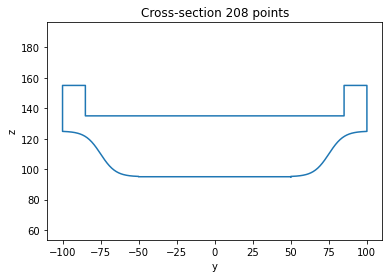

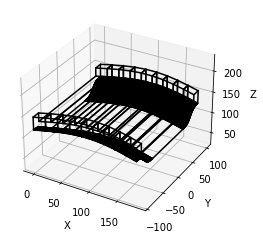

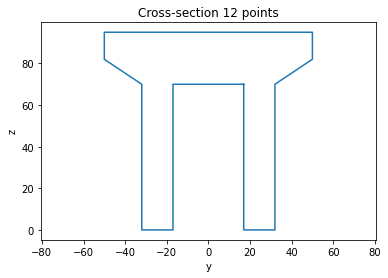

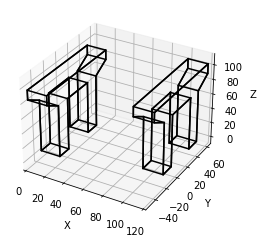

In [12]:
class CrossSection:

    def __init__(self): 
        self.yz=None
        self.C=None
        
    def Deck(self,b,c,d,e,f,a=50,h=95):
        x=np.linspace(-5,5,100)
        y=1./(1.+np.exp(-x))
        x=x*b/10+b/2+a
        y=y*c+h
        yz=np.array([
            [a+b,h+c+d+e],
            [a+b-f,h+c+d+e],
            [a+b-f,h+c+d],
            [-(a+b-f),h+c+d],
            [-(a+b-f),h+c+d+e],
            [-a-b,h+c+d+e],
        ])
        s=np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
        yz=np.concatenate((s,yz),axis=0)
        s[:,0]=-s[:,0]
        s=s[::-1]
        yz=np.concatenate((yz,s),axis=0)
        yz=np.concatenate((np.array([[50,h]]),yz),axis=0)
        yz=np.concatenate((yz,np.array([[-50,h]])),axis=0)
        self.yz = yz
        self.addsection()
        return yz
    def Column(self,a,b,c,d,e,f):
            
        yz=np.array([
            [a,d],
            [a,0],
            [a+b,0],
            [a+b,d],
            [a+b+c,d+e],
            [a+b+c,d+e+f],
            [-(a+b+c),d+e+f],
            [-(a+b+c),d+e],
            [-(a+b),d],
            [-(a+b),0],
            [-a,0],
            [-a,d]
        ])
        self.yz = yz
        self.addsection()
        return yz
    
    def addsection(self):
        yz = self.yz.reshape((1,self.yz.shape[0],self.yz.shape[1])) #shape: 0-row 1-column #reshape: change to yz plane 1代表1面
        if self.C is None: #注意写法
            self.C = yz
        else:
            self.C = np.concatenate((self.C,yz),0) #concatenate: 矩阵叠加. 这里是在x轴上重复 (0-x 1-y 2-z) 代表一个面叠加为一个矩阵
        return self.C #所有面都重叠在一起
    
    def Show(self,double):
        if double == False:
            idx = np.mod(np.arange(self.yz.shape[0]+1),self.yz.shape[0]) #连接封闭二维图形的惯用写法
            plt.figure()  #begin drawing
            plt.plot(self.yz[idx,0],self.yz[idx,1]) #连接封闭二维图形的惯用写法
            plt.xlabel('y'); plt.ylabel('z')
            plt.axis('equal')
            plt.title("Cross-section {:d} points".format(self.yz.shape[0]))
        else:
            idx=np.mod(np.arange(int(self.yz.shape[0]/2+1)),int(self.yz.shape[0]/2))
            plt.plot(self.yz[idx,0],self.yz[idx,1])
            plt.plot(self.yz[idx+int(self.yz.shape[0]/2),0],self.yz[idx+int(self.yz.shape[0]/2),1]) #矩阵可以直接加常数
            plt.xlabel('y'); plt.ylabel('z')
            plt.axis('equal')
            plt.title("Cross-section {:d} points".format(self.yz.shape[0]))





        def addsection(self):
            yz = self.yz.reshape((1,self.yz.shape[0],self.yz.shape[1])) #shape: 0-row 1-column #reshape: change to yz plane 1代表1面
            if self.C is None: #注意写法
                self.C = yz
            else:
                self.C = np.concatenate((self.C,yz),0) #concatenate: 矩阵叠加. 这里是在x轴上重复 (0-x 1-y 2-z) 代表一个面叠加为一个矩阵
            return self.C #所有面都重叠在一起
        

##########################################################################################################################################
class Member:
    def __init__(self,C,t1,t2):
        self.n = C.shape[0] #number of faces
        self.npts = C.shape[1] #number of vertices in one face
        
        #################trans
        t = np.zeros((self.n,3)) #np.array(a,b): a行b列, column is xyz coordinate, row is number of faces 
        t[:,0] = np.arange(self.n)*20 #第一列: 0--(self.n-1) #只要在x轴上转制，先埋好伏笔，且推进为20
        n=self.n
        omega = np.pi / (n-1)
        t[:,1] = np.sin(omega*np.arange(n))*t1  # y direction
        t[:,2] = np.sin(omega*np.arange(n))*t2  # z direction
        self.t= t

        #################rotate
        # rotvec = np.zeros((n,3))
        # rotvec[:,2]=np.arctan(omega * t1 * np.cos(omega*np.arange(n))) #y direction (z rotate)
        # rotvec[:,1]=-np.arctan(omega * t2 * np.cos(omega*np.arange(n)))
        # self.R = R.from_rotvec(rotvec)   #把四元数转化为旋转矩阵

        self.v = [] #vertices
        self.f = [] #faces

        xyz = np.zeros((self.npts,3)) #对之前C里的每个面进行处理, xyz只代表一个面
        for i in range(self.n):
            xyz[:,1:] = C[i,:,:] #xyz所有行,第二列开始到最后一列 x坐标全是0 #这里对C的处理是把每一个面提取出来 
            #c = self.R[i].apply(xyz) + self.t[i,:] #self.R[i]: 第i个旋转矩阵 #先旋转，再移动  #self.t这里的写法是broadcast
            c = xyz + self.t[i,:]
            self.v = self.v + [(c[k,0],c[k,1],c[k,2]) for k in range(self.npts)]  #(c[k,0],c[k,1],c[k,2]) is a list. 
            #if i==0:
                #idx=np.mod(np.arange(self.npts+1),self.npts)
                #self.f=[idx.tolist()]
            if i>0:
                m = self.npts * (i-1)
                idx1 = np.arange(m,m+self.npts)    #arrange包括开始 不包括结束
                idx2 = np.arange(m+self.npts,m+2*self.npts) 
                self.f = self.f + [(idx1[k],idx1[np.mod(k+1,self.npts)],idx2[np.mod(k+1,self.npts)],idx2[k]) for k in range(self.npts)]

    def Show(self):
        v = np.array(self.v)
        plt.figure()
        ax = plt.axes(projection='3d')
        for f in self.f: #把list f中矩阵一个个调用
            #print(f)
            idxv = np.array(f)
            ax.plot3D(v[idxv,0], v[idxv,1], v[idxv,2], 'k') #把idxv矩阵对应的四个点找出来
            
        vmin = v.min(0); vmax = v.max(0); ctr = (vmin+vmax)/2.  #min(0) is the minimum of every column, min(1) is the minimum of every row min() is the minimum of all number #这里是找到中间面
        half = (vmax-vmin).max()/2.
        ax.set_xlim((ctr[0]-half,ctr[0]+half))
        ax.set_ylim((ctr[1]-half,ctr[1]+half))
        ax.set_zlim((ctr[2]-half,ctr[2]+half)) #合适的显示区域
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

class Member_column:
        def __init__(self,C,trans,thick): 
            self.n = C.shape[0] #number of faces
            self.npts = C.shape[1] #number of vertices in one face
            #up_down=np.zeros(self.trans.shape[:,1])
            xyz = np.zeros((self.npts,3)) #对之前C里的每个面进行处理, xyz只代表一个面  *2:thinkness of column

            self.v = [] #vertices
            self.f = [] #faces
            dist=5
            for i in range(math.floor(self.n/dist)):
                xyz[:,1:] = C[i*dist,:,:] #xyz所有行,第二列开始到最后一列 x坐标全是0 #这里对C的处理是把每一个面提取出来
                #c = self.R[i].apply(xyz) + self.t[i,:] #self.R[i]: 第i个旋转矩阵 #先旋转，再移动  #self.t这里的写法是broadcast
                c = xyz + trans[i*dist,:]
                self.v = self.v + [(c[k,0],c[k,1],c[k,2]) for k in range(self.npts)]  #(c[k,0],c[k,1],c[k,2]) is a list
            
            xyz = np.zeros((self.npts,3))
            for i in range(math.floor(self.n/dist)):  #thickness  #总共(math.floor(self.n/10))*2个faces
                xyz[:,1:] = C[i*dist,:,:]
                c = xyz + trans[i*dist,:]+np.array([thick,0,0])
                self.v = self.v + [(c[k,0],c[k,1],c[k,2]) for k in range(self.npts)]  #need further revise
                
                ##faces
                m = self.npts*(i)
                idx1 = np.arange(m,m+self.npts)    #arrange包括开始 不包括结束 #first face
                idx2 = np.arange(m+self.npts*math.floor(self.n/dist),m+2*self.npts*math.floor(self.n/dist))  #second face
                self.f = self.f + [(idx1[k],idx1[np.mod(k+1,self.npts)],idx2[np.mod(k+1,self.npts)],idx2[k]) for k in range(self.npts)]

            for i in range((math.floor(self.n/dist))*2): #local face
                idx=np.mod(np.arange(self.npts+1),self.npts)+self.npts*i
                self.f=self.f+[tuple(idx)]

        def Show(self):
            v = np.array(self.v)
            plt.figure()
            ax = plt.axes(projection='3d')
            for ff in self.f: #把list f中矩阵一个个调用
            #print(f)
                idxv = np.array(ff)
                ax.plot3D(v[idxv,0], v[idxv,1], v[idxv,2], 'k') #把idxv矩阵对应的四个点找出来
            
            vmin = v.min(0); vmax = v.max(0); ctr = (vmin+vmax)/2.  #min(0) is the minimum of every column, min(1) is the minimum of every row min() is the minimum of all number #这里是找到中间面
            half = (vmax-vmin).max()/2.
            ax.set_xlim((ctr[0]-half,ctr[0]+half))
            ax.set_ylim((ctr[1]-half,ctr[1]+half))
            ax.set_zlim((ctr[2]-half,ctr[2]+half)) #合适的显示区域
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

            
        
###############################################################################################################################################

if __name__ == "__main__":
    t=10
    cs = CrossSection()
    for i in range(t):
    # create constant rectangular cross section
        cs.Deck(50,30,10,20,15)
    cs.Show(False)
    m=Member(cs.C,10,10)
    m.Show()
    #print(m.t)
    col=CrossSection()
    for i in range(t):
        col.Column(17,15,18,70,12,13)
    col.Show(False)
    n=Member_column(col.C,m.t,20)
    n.Show()

